# Visualize your genotypes in the 1000 Genomes Project Population Space

This notebook will show you how to transform yor genotype data into reduced dimensions using the 1kGP as reference populations.  
Dimensionality Redcution techniques include PCA, t-SNE, and UMAP.  
Also, check out the [interactive visualization app](tgviz.herokuapp.com).

### Install additional libraries

In [1]:
%%bash
conda install -c bioconda pbgzip tabix -y 
pip install cmake cyvcf2 MulticoreTSNE umap
pip install --upgrade scikit-learn

Fetching package metadata ...............
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    intel-openmp:   2019.1-144                    defaults   
    libgfortran-ng: 7.2.0-hdf63c60_3              conda-forge
    mkl:            2018.0.3-1                    defaults   
    pbgzip:         2016.08.04-he4cf2ce_0         bioconda   
    tabix:          0.2.6-ha92aebf_0              bioconda   

The following packages will be UPDATED:

    scikit-learn:   0.18.2-py36_blas_openblas_201 conda-forge [blas_openblas] --> 0.19.1-py36hedc7406_0 defaults   
    scipy:          0.19.1-py36_blas_openblas_202 conda-forge [blas_openblas] --> 1.1.0-py36hc49cb51_0  defaults   

The following packages will be DOWNGRADED:

    blas:           1.1-openblas                  conda-forge --> 1.0-mkl               defaults   
    gsl:            2.2.1-blas_openblas_3         conda-forge [blas_openblas] --> 2.1-2  

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import bz2
import os
import io
import requests
import pandas as pd
import numpy as np
import umap


from MulticoreTSNE import MulticoreTSNE as TSNE
from ohapi import api
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from cyvcf2 import VCF, Writer

import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

### Convert a .vcf of the 1000 Genomes Project sample genotypes to a pandas DataFrame

The reference `.vcf` has been created and [steps documented](https://github.com/arvkevi/tgviz/blob/master/notebooks/generate_aisnp_1kG_vcf.ipynb) by subsetting 1kGP sample genotypes to ancestry informative SNPs (AISNPs). 
1. 55 AISNPs [published by Kidd et al. ](https://www.sciencedirect.com/science/article/pii/S1872497314000039)
or
2. 128 AISNPs [published by Kosoy et al.](https://www.ncbi.nlm.nih.gov/pubmed?cmd=Retrieve&dopt=citation&list_uids=18683858)

In [3]:
def vcf2df(vcf_fname):
    """Convert a subsetted vcf file to pandas DataFrame
    and return sample-level population data"""
    samples = 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
    dfsamples = pd.read_csv(samples, sep='\t')
    dfsamples.set_index('sample', inplace=True)
    dfsamples.drop(['Unnamed: 4', 'Unnamed: 5'], inplace=True, axis=1)

    vcf_file = VCF(vcf_fname)
    df = pd.DataFrame(index=vcf_file.samples)
    for variant in vcf_file():
        df[variant.ID] = variant.gt_types

    df = df.join(dfsamples, how='outer')
    df = df.drop(['pop', 'super_pop', 'gender'], axis=1)

    return df, dfsamples

### Choose which AISNPs  set to use 

In [4]:
# Kidd et al.
aisnps = 55

# Kosoy et al.
# aisnps = 128

In [5]:
if aisnps == 55:
    vcf_fname = 'https://s3.amazonaws.com/ancestry-snps-1kgp/Kidd.55AISNP.1kG.vcf'
elif aisnps == 128:
    vcf_fname = 'https://s3.amazonaws.com/ancestry-snps-1kgp/Seldin.128AISNP.1kG.vcf'

df, dfsamples = vcf2df(vcf_fname)

0 - ref/ref  
1 - ref/alt  
2 - Unknown  
3 - alt/alt

In [22]:
df.head(3)

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
HG00096,0,1,0,3,0,0,0,1,0,3,...,0,0,1,0,0,3,3,1,1,0
HG00097,0,3,0,3,0,0,0,0,0,3,...,1,0,3,0,0,3,1,0,0,1
HG00099,0,1,0,1,3,1,0,3,0,3,...,0,0,1,0,0,1,1,0,0,1


In [23]:
dfsamples.head(3)

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female


### Now add your OpenHumans vcf data

In [24]:
user = api.exchange_oauth2_member(os.environ.get('OH_ACCESS_TOKEN'))

# 128 - 23andMe Upload
# 129 - AncestryDNA Upload
# 120 - FamilyTreeDNA Upload
# 40 - Gencove Upload
# 131 - Genome/Exome Upload
# uncomment the project_source below depending on which you would like to use

project_source = 'direct-sharing-128'
#project_source = 'direct-sharing-129'
#project_soucre = 'direct-sharing-120'
#project_soucre = 'direct-sharing-40'
#project_soucre = 'direct-sharing-131'

# Get a .vcf from OpenHumans
for record in user['data']:
    if record['source'] == project_source and '.vcf' in record['basename']:
        print('Found your imputed genotype data in Open Humans!')
        datafile = requests.get(record['download_url'])
        with open('member.vcf', 'wb') as handle:
            try:
                try:
                    try:
                        textobj = bz2.decompress(datafile.content)
                        handle.write(textobj)
                    except OSError:
                        textobj = gzip.decompress(datafile.content)
                        handle.write(textobj)
                except OSError:
                    for block in datafile.iter_content(1024):
                        handle.write(block)
            except:
                logger.critical('your data source file is malformated')
        break

Found your imputed genotype data in Open Humans!


### append your data to the reference data

In [25]:
# start with UNKNOWN genotypes == 2 in cyvcf
df.loc['me'] = np.repeat([2], df.shape[1])

dfsamples.loc['me'] = ['me', 'me', 'male']

In [26]:
# read the raw AISNPs tables from the manuscripts, w/ genomic location and rsid
if aisnps == 55:
    dfaim = pd.read_csv('https://s3.amazonaws.com/ancestry-snps-1kgp/Kidd_55_AISNPs.txt', sep='\t')
elif aisnps == 128:
    dfaim = pd.read_csv('https://s3.amazonaws.com/ancestry-snps-1kgp/Seldin_128_AISNPs.txt', sep='\t')

The .vcf file must be bgzip'ed and tabix indexed

In [27]:
%%bash
pbgzip member.vcf
tabix member.vcf.gz

[pbgzip] member.vcf.gz already exists; do you wish to overwrite (y or n)? [pbgzip] not overwritten


In [28]:
# must be bgzipped and tabix indexed
myvcf = VCF('member.vcf.gz')

for i, row in dfaim.iterrows():
    chrom = row['Chr']
    pos = row['Build 37 nt position'].replace(',', '')
    rsid = row['dbSNP rs#']
    for variant in myvcf(f'{chrom}:{pos}-{pos}'):
        df.loc['me', row['dbSNP rs#']] = variant.gt_types[0] 

### One-Hot Encode the DataFrame

In [29]:
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)

In [30]:
def reduce_dim(X, algorithm='PCA', n_components=4):
    """Reduce the dimensionality of the 55 AISNPs
    :param X: One-hot encoded 1kG 55 AISNPs.
    :type X: array
    :param algorithm: The type of dimensionality reduction to perform. 
        One of {PCA, UMAP, TSNE}
    :type algorithm: str 
    :param n_components: The number of components to return in X_red 
    :type n_components: int
    
    :returns: The transformed X[m, n] array, reduced to X[m, n_components] by algorithm.
    """
    
    if algorithm == 'PCA':
        X_red = PCA(n_components=n_components).fit_transform(X)
    elif algorithm == 'TSNE':
        # TSNE, Barnes-Hut have dim <= 3
        if n_components > 3:
            print('The Barnes-Hut method requires the dimensionaility to be <= 3')
            return None
        else:
            X_red = TSNE(n_components=n_components, n_jobs=4).fit_transform(X)
    elif algorithm == 'UMAP':
        X_red = umap.UMAP(n_components=n_components).fit_transform(X)
    else:
        return None
    return X_red

### Choose the dimensionality reduction algorithm.

{PCA, TSNE, or UMAP}

In [31]:
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

In [32]:
def encode_class(pop_level='pop'):
    """Encode the population lables for plotting."""
    le = LabelEncoder()
    if pop_level == 'pop':
        labels = le.fit_transform(dfsamples['pop'].values)
    elif pop_level == 'super_pop':
        labels = le.fit_transform(dfsamples['super_pop'].values)
    else:
        return None
    return le, labels

In [33]:
# pop_level can be either 'pop' or 'super_pop'
le, labels = encode_class(pop_level='super_pop')

In [34]:
def plot_samples(X_emb, x_component=None, y_component=None):
    """"""
    unique = np.unique(labels)
    colors = [plt.cm.tab10_r(i/float(len(unique)-1)) for i in range(len(unique))]
    assignments = [colors[i] for i in labels]

    plt.figure(figsize=(10,10));
    for (i,cla) in enumerate(set(labels)):
        s = None
        if le.inverse_transform([cla])[0] == 'me':
            s=500
        xc = [p for (j,p) in enumerate(X_emb[:, x_component-1]) if labels[j]==cla]
        yc = [p for (j,p) in enumerate(X_emb[:, y_component-1]) if labels[j]==cla]
        cols = [c for (j,c) in enumerate(assignments) if labels[j]==cla]
        plt.scatter(xc, yc, s=s, c=cols, label=le.inverse_transform([cla])[0])
    plt.legend();
    plt.xlabel('Component {}'.format(x_component));
    plt.ylabel('Component {}'.format(y_component));
    plt.title('Projection of 1000 Genomes Samples\ninto Lower Dimensional Space');

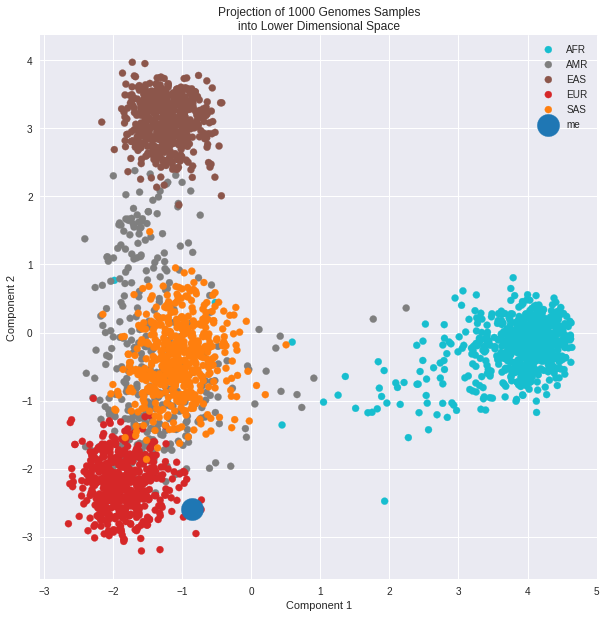

In [35]:
plot_samples(X_emb, x_component=1, y_component=2)

### Compare imputed genotypes to raw 23andMe data

In [36]:
# using your imputed genotypes from Imputer
for record in user['data']:
    if record['basename'] == 'member.imputed.vcf.bz2':
        print('Found your imputed genotype data in Open Humans!')
        with open('member.imputed.vcf', 'wb') as handle:
            datafile = requests.get(record['download_url']).content
            datafile = bz2.decompress(datafile)
            handle.write(datafile)
        break

Found your imputed genotype data in Open Humans!


In [37]:
%%bash
pbgzip member.imputed.vcf
tabix member.imputed.vcf.gz

[pbgzip] member.imputed.vcf.gz already exists; do you wish to overwrite (y or n)? [pbgzip] not overwritten


# Compare the plot with the imputed genotypes

In [38]:
me_gts = df.loc['me'].value_counts()

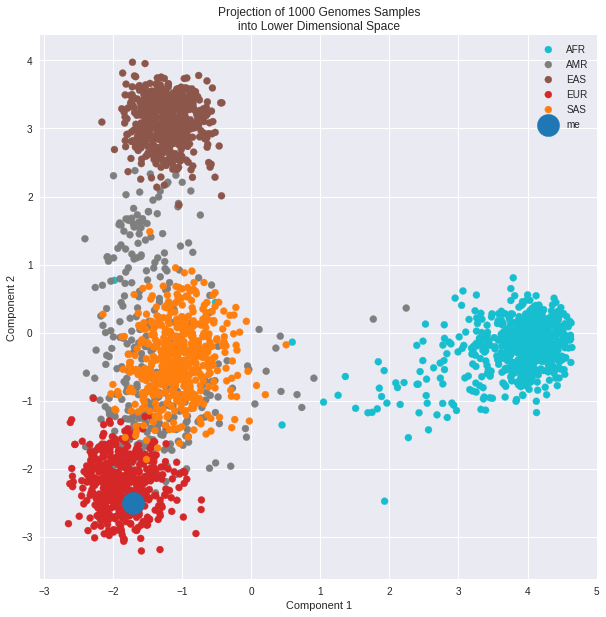

In [39]:
myvcf = VCF('member.imputed.vcf.gz')

for i, row in dfaim.iterrows():
    chrom = row['Chr']
    pos = row['Build 37 nt position'].replace(',', '')
    rsid = row['dbSNP rs#']
    for variant in myvcf(f'{chrom}:{pos}-{pos}'):
        df.loc['me', row['dbSNP rs#']] = variant.gt_types[0]
        
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

le, labels = encode_class(pop_level='super_pop')

plot_samples(X_emb, x_component=1, y_component=2)       

In [40]:
me_gts_imputed = df.loc['me'].value_counts()

In [41]:
# The count of 2's is the number of missing genotypes in your un-imputed vcf
me_gts

0    28
2    11
3     8
1     8
Name: me, dtype: int64

In [42]:
# The count of 2's is the number of missing genotypes in your imputed vcf
me_gts_imputed

0    32
3    12
1    11
Name: me, dtype: int64